In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib.ticker import ScalarFormatter

In [63]:
def extract_variation(row):
    experiment_name = row['ExperimentName']
    names = experiment_name.split(" | ")
    extracted_variations = []

    for name in names:
        variation = name.split("=")[-1]
        extracted_variations.append(variation)
    return " | ".join(extracted_variations)


def get_last_items(log_file: str) -> pd.DataFrame:
    df = pd.read_csv(log_file)
    experiments = df['ExperimentName'].drop_duplicates()
    last_item_frames = [df[df['ExperimentName'] == experiment].iloc[[-1]] for experiment in experiments]
    last_items = pd.concat(last_item_frames)
    last_items['Variation'] = last_items.apply(extract_variation, axis=1)
    last_items.insert(0, 'New_Numbering', range(len(last_items)))
    return last_items

def plot_log_dir(log_dir: str, baseline_name="baseline", highlight=3):
    log_files = [f"{log_dir}/{file}" for file in os.listdir(log_dir)]

    baseline_mean = 0.1
    if default := [log for log in log_files if f"trace-{baseline_name}.csv" in log]:
        default = default[0]
        log_files.remove(default)
        baseline_mean = get_last_items(default).loc[:, 'AveBestFitness'].mean()

    frames = [get_last_items(log_file) for log_file in log_files]

    fig, axs = plt.subplots(1, len(frames), figsize=(max(5*len(frames),10), 8), sharey=True, layout='constrained')
    for df, log_file, ax in zip(frames, log_files, axs):
        ax.plot(df['New_Numbering'], df['AveBestFitness'], 'o-', label="Experiments")
        # Highlight our 3 minimum values
        smallest = df.nsmallest(highlight, "AveBestFitness")
        ax.plot(smallest['New_Numbering'], smallest['AveBestFitness'], 'o', label=f"Lowest {highlight}")

            # General formatting for the plot
        ax.set_xlabel(log_file.split("/trace-")[-1].removesuffix(".csv"))
        ax.grid(True)
        current_mean = df.loc[:, 'AveBestFitness'].mean()

        # axs.hlines(y=default_last_val, xmin=0, xmax=len(last_items)-1, color='r', label=f"Default {round(default_last_val, 4)}")
        # axs.hlines(y=combination_last_val, xmin=0, xmax=len(last_items)-1, color='g', label=f"Combination of Best {round(combination_last_val, 4)}")
        ax.hlines(y=current_mean, xmin=0, xmax=len(df)-1, color='yellow', label=f"Mean {round(current_mean,4)}")
        ax.hlines(y=baseline_mean, xmin=0, xmax=len(df)-1, color='brown', label=f"Baseline Mean {round(baseline_mean,4)}")
        ax.legend()

        ax.set_xticks(range(len(df)))
        ax.set_xticklabels(df['Variation'], rotation=90)
        for _, row in smallest.iterrows():
            ax.get_xticklabels()[row['New_Numbering']].set_color("orange")
            ax.text(row['New_Numbering']+min(.08*len(df), 1.1), row['AveBestFitness'], f"{round(row['AveBestFitness'], 4)}", ha="center", color='orange', rotation=45)

        # Format the y-axis to be log scale, but still show whole numbers, and to display ticks next to each chart
        ax.set_yscale('log')
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.yaxis.set_tick_params(labelbottom=True)

    fig.supylabel('Fitness (=> 0)')
    plt.show()




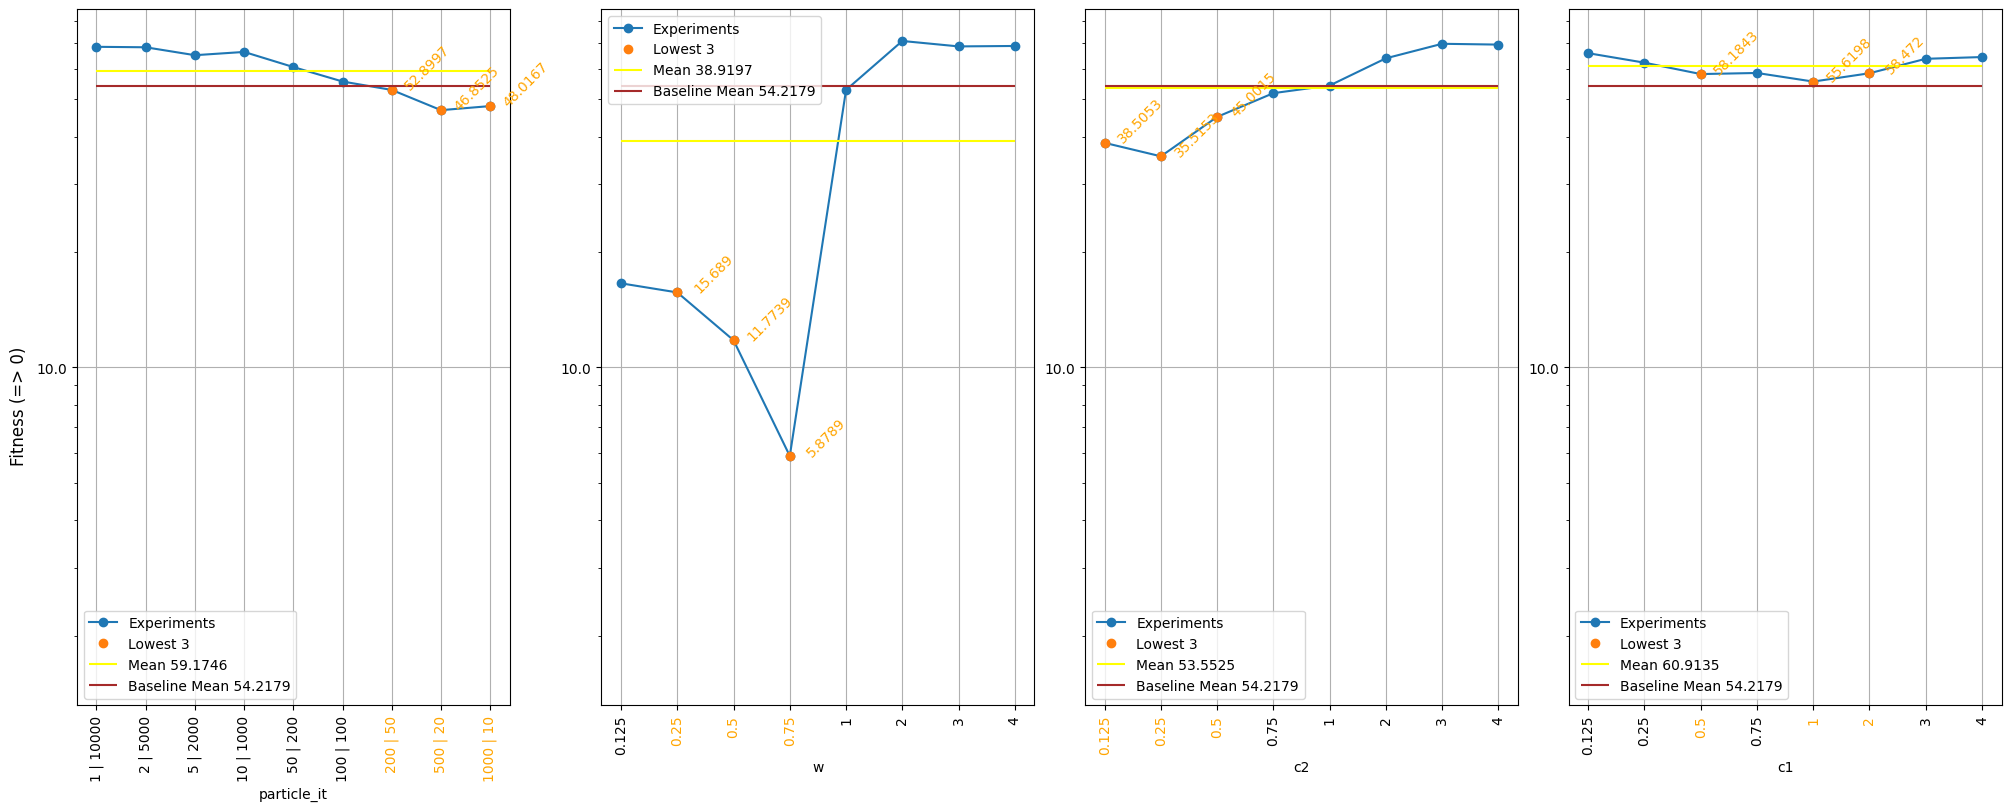

In [64]:
plot_log_dir("PSO_Logs")